# Задача 1. 
Выгрузил демонтрационную база даннух dvdrental оптимизированную сразу для PostgreSQL по следующей ссылке 
https://neon.tech/postgresql/postgresql-getting-started/postgresql-sample-database (можете обновить учебные материалы)

In [2]:
!curl -O https://neon.tech/postgresqltutorial/dvdrental.zip && unzip dvdrental.zip && createdb -U postgres dvdrental && pg_restore -U postgres -d dvdrental dvdrental.tar

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  537k  100  537k    0     0   723k      0 --:--:-- --:--:-- --:--:--  723k
Archive:  dvdrental.zip
  inflating: dvdrental.tar           


In [3]:
!psql postgres -U postgres -d dvdrental -c "\dt+"

psql: warning: extra command-line argument "postgres" ignored
                                         List of relations
 Schema |     Name      | Type  |  Owner   | Persistence | Access method |    Size    | Description 
--------+---------------+-------+----------+-------------+---------------+------------+-------------
 public | actor         | table | postgres | permanent   | heap          | 40 kB      | 
 public | address       | table | postgres | permanent   | heap          | 88 kB      | 
 public | category      | table | postgres | permanent   | heap          | 8192 bytes | 
 public | city          | table | postgres | permanent   | heap          | 64 kB      | 
 public | country       | table | postgres | permanent   | heap          | 8192 bytes | 
 public | customer      | table | postgres | permanent   | heap          | 96 kB      | 
 public | film          | table | postgres | permanent   | heap          | 464 kB     | 
 public | film_actor    | table | postgres | permanent

# Задача 2.

In [4]:
import os
import pandas as pd
from sqlalchemy import create_engine

# Параметры подключения к PostgreSQL
db_params = {
    "dbname": "dvdrental",
    "user": "postgres",
    "password": "postgres",
    "host": "localhost",
    "port": 5432
}

# Подключение к базе данных
engine = create_engine(f"postgresql://{db_params['user']}:{db_params['password']}@{db_params['host']}:{db_params['port']}/{db_params['dbname']}")

data_dir = "data_csv"
os.makedirs(data_dir, exist_ok=True)

try:
    # 1. Доля фильмов в каждой рейтинговой категории
    query1 = """
    SELECT rating, COUNT(*) * 100.0 / SUM(COUNT(*)) OVER() AS percentage
    FROM film
    GROUP BY rating;
    """
    df1 = pd.read_sql(query1, engine)
    df1.to_csv(os.path.join(data_dir, "rating_distribution.csv"), index=False)

    # 2. Какие категории фильмов чаще всего арендуются клиентами
    query2 = """
    SELECT c.name, COUNT(r.rental_id) AS rental_count
    FROM rental r
    JOIN inventory i ON r.inventory_id = i.inventory_id
    JOIN film f ON i.film_id = f.film_id
    JOIN film_category fc ON f.film_id = fc.film_id
    JOIN category c ON fc.category_id = c.category_id
    GROUP BY c.name
    ORDER BY rental_count DESC;
    """
    df2 = pd.read_sql(query2, engine)
    df2.to_csv(os.path.join(data_dir, "most_rented_categories.csv"), index=False)

    # 3. Средняя продолжительность проката для каждой категории
    query3 = """
    SELECT c.name, AVG(f.rental_duration) AS avg_rental_duration
    FROM film f
    JOIN film_category fc ON f.film_id = fc.film_id
    JOIN category c ON fc.category_id = c.category_id
    GROUP BY c.name;
    """
    df3 = pd.read_sql(query3, engine)
    df3.to_csv(os.path.join(data_dir, "avg_rental_duration.csv"), index=False)

    # 4. Тенденции в ежемесячном доходе от проката за год
    query4 = """
    SELECT DATE_TRUNC('month', payment_date) AS month, SUM(amount) AS revenue
    FROM payment
    WHERE payment_date >= NOW() - INTERVAL '1 year'
    GROUP BY month
    ORDER BY month;
    """
    df4 = pd.read_sql(query4, engine)
    df4.to_csv(os.path.join(data_dir, "monthly_revenue.csv"), index=False)

    # 5. Сравнение показателей продаж в разных магазинах
    query5 = """
    SELECT s.store_id, SUM(p.amount) AS total_sales
    FROM payment p
    JOIN rental r ON p.rental_id = r.rental_id
    JOIN inventory i ON r.inventory_id = i.inventory_id
    JOIN store s ON i.store_id = s.store_id
    GROUP BY s.store_id;
    """
    df5 = pd.read_sql(query5, engine)
    df5.to_csv(os.path.join(data_dir, "store_sales.csv"), index=False)

    # 6. Средние затраты на замену фильмов в разных жанрах
    query6 = """
    SELECT c.name, AVG(f.replacement_cost) AS avg_replacement_cost
    FROM film f
    JOIN film_category fc ON f.film_id = fc.film_id
    JOIN category c ON fc.category_id = c.category_id
    GROUP BY c.name;
    """
    df6 = pd.read_sql(query6, engine)
    df6.to_csv(os.path.join(data_dir, "replacement_cost.csv"), index=False)

    # 7. Актеры, снимающиеся в самых разных жанрах
    query7 = """
    SELECT a.actor_id, a.first_name, a.last_name, COUNT(DISTINCT fc.category_id) AS genre_count
    FROM actor a
    JOIN film_actor fa ON a.actor_id = fa.actor_id
    JOIN film_category fc ON fa.film_id = fc.film_id
    GROUP BY a.actor_id, a.first_name, a.last_name
    ORDER BY genre_count DESC;
    """
    df7 = pd.read_sql(query7, engine)
    df7.to_csv(os.path.join(data_dir, "actors_by_genre.csv"), index=False)

    print("Все запросы выполнены и данные сохранены в папке 'data_csv'.")

finally:
    engine.dispose()
    print("Соединение с базой данных закрыто.")

Все запросы выполнены и данные сохранены в папке 'data_csv'.
Соединение с базой данных закрыто.


/var/folders/4w/vbk4jcv15kzgrcwpgscbkh2h0000gn/T/ipykernel_1737/3313966479.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="rating", y="percentage", data=df_rating, palette="coolwarm")


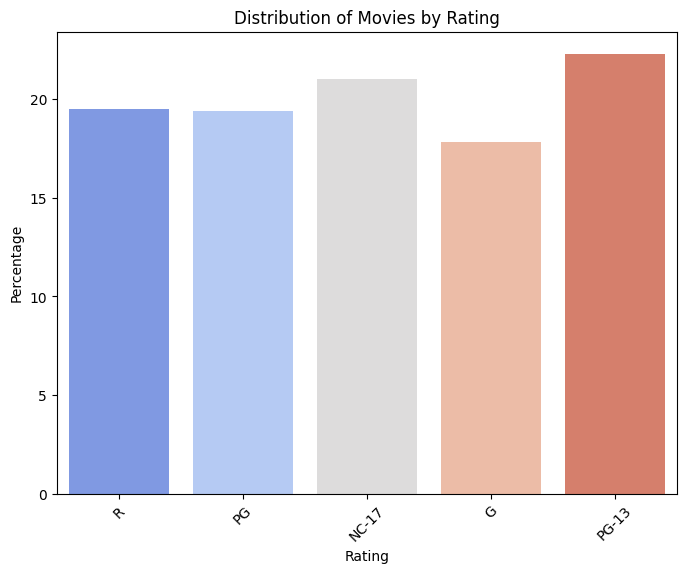

/var/folders/4w/vbk4jcv15kzgrcwpgscbkh2h0000gn/T/ipykernel_1737/3313966479.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="rental_count", y="name", data=df_rented, palette="viridis")


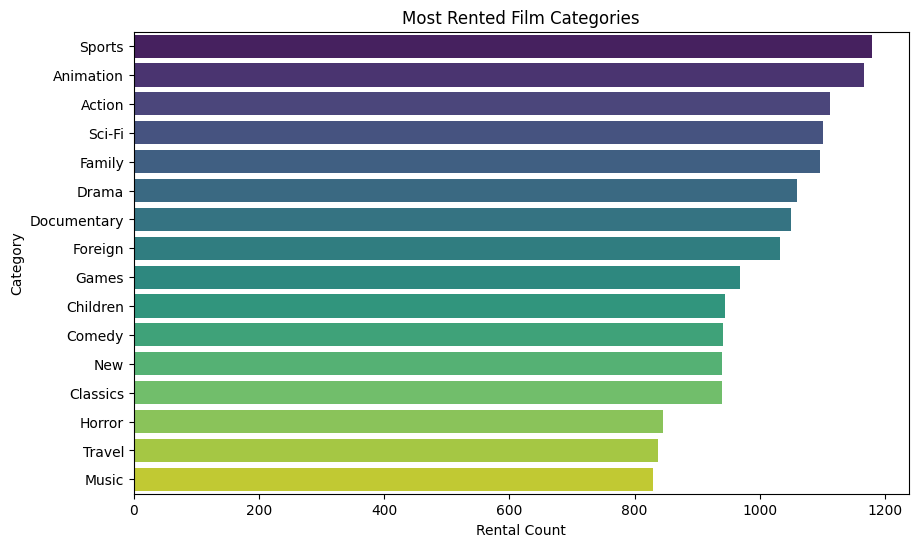

/var/folders/4w/vbk4jcv15kzgrcwpgscbkh2h0000gn/T/ipykernel_1737/3313966479.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="avg_rental_duration", y="name", data=df_duration, palette="Blues_r")


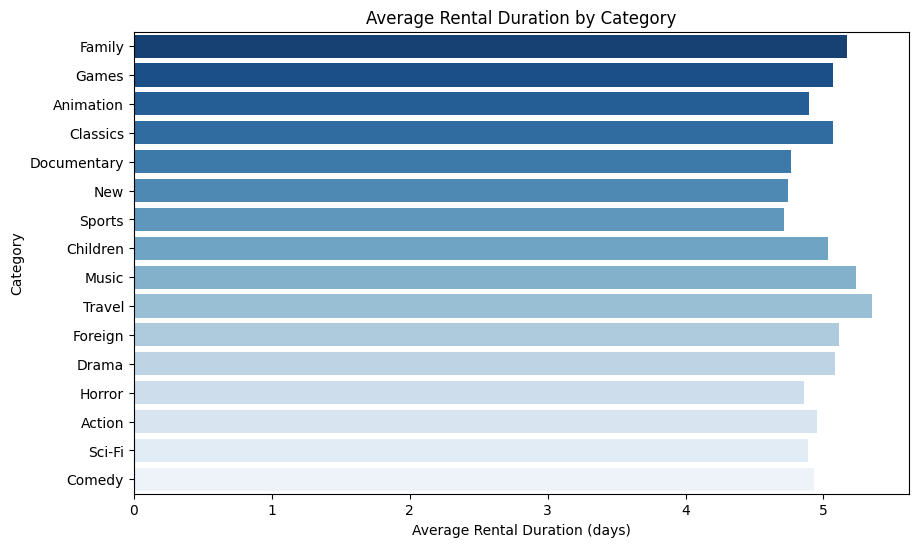

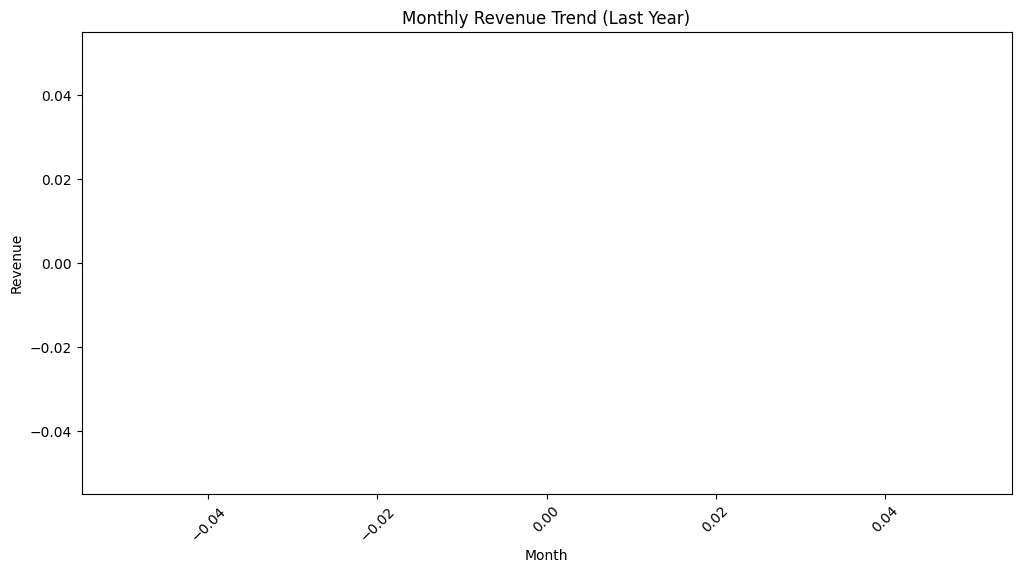

/var/folders/4w/vbk4jcv15kzgrcwpgscbkh2h0000gn/T/ipykernel_1737/3313966479.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="store_id", y="total_sales", data=df_sales, palette="magma")


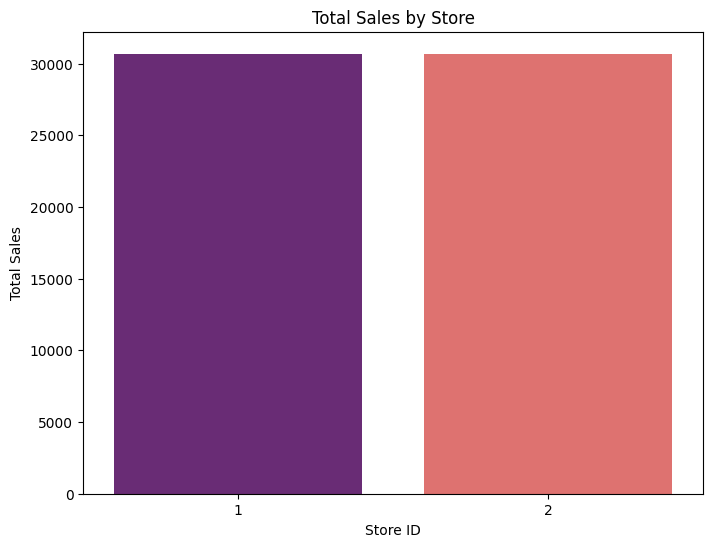

/var/folders/4w/vbk4jcv15kzgrcwpgscbkh2h0000gn/T/ipykernel_1737/3313966479.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="avg_replacement_cost", y="name", data=df_replacement, palette="Greens_r")


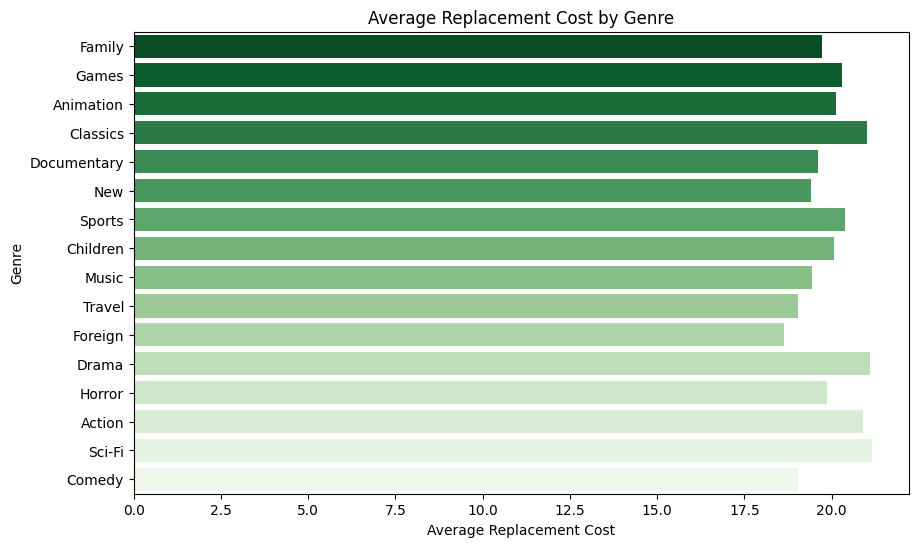

/var/folders/4w/vbk4jcv15kzgrcwpgscbkh2h0000gn/T/ipykernel_1737/3313966479.py:74: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="genre_count", y=df_actors["first_name"] + " " + df_actors["last_name"], data=df_actors, palette="coolwarm")


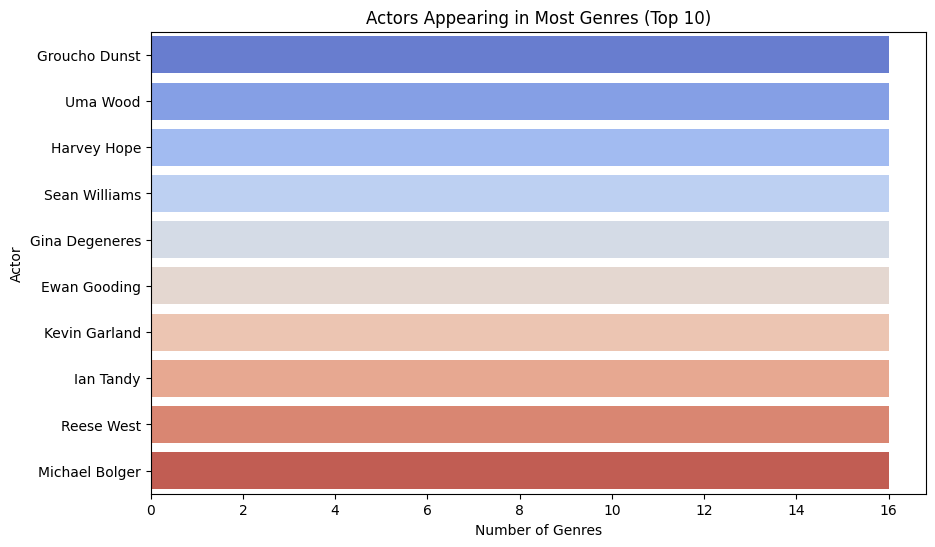

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

files = {
    "actors_by_genre": "data_csv/actors_by_genre.csv",
    "avg_rental_duration": "data_csv/avg_rental_duration.csv",
    "monthly_revenue": "data_csv/monthly_revenue.csv",
    "most_rented_categories": "data_csv/most_rented_categories.csv",
    "rating_distribution": "data_csv/rating_distribution.csv",
    "replacement_cost": "data_csv/replacement_cost.csv",
    "store_sales": "data_csv/store_sales.csv"
}

# 1. Доля фильмов в каждой рейтинговой категории
df_rating = pd.read_csv(files["rating_distribution"])
plt.figure(figsize=(8, 6))
sns.barplot(x="rating", y="percentage", data=df_rating, palette="coolwarm")
plt.title("Distribution of Movies by Rating")
plt.ylabel("Percentage")
plt.xlabel("Rating")
plt.xticks(rotation=45)
plt.show()

# 2. Какие категории фильмов чаще всего арендуются клиентами
df_rented = pd.read_csv(files["most_rented_categories"])
plt.figure(figsize=(10, 6))
sns.barplot(x="rental_count", y="name", data=df_rented, palette="viridis")
plt.title("Most Rented Film Categories")
plt.xlabel("Rental Count")
plt.ylabel("Category")
plt.show()

# 3. Средняя продолжительность проката для каждой категории
df_duration = pd.read_csv(files["avg_rental_duration"])
plt.figure(figsize=(10, 6))
sns.barplot(x="avg_rental_duration", y="name", data=df_duration, palette="Blues_r")
plt.title("Average Rental Duration by Category")
plt.xlabel("Average Rental Duration (days)")
plt.ylabel("Category")
plt.show()

# 4. Тенденции в ежемесячном доходе от проката за год
df_revenue = pd.read_csv(files["monthly_revenue"])
df_revenue["month"] = pd.to_datetime(df_revenue["month"])
plt.figure(figsize=(12, 6))
sns.lineplot(x="month", y="revenue", data=df_revenue, marker="o", color="red")
plt.title("Monthly Revenue Trend (Last Year)")
plt.xlabel("Month")
plt.ylabel("Revenue")
plt.xticks(rotation=45)
plt.show()

# 5. Сравнение показателей продаж в разных магазинах
df_sales = pd.read_csv(files["store_sales"])
plt.figure(figsize=(8, 6))
sns.barplot(x="store_id", y="total_sales", data=df_sales, palette="magma")
plt.title("Total Sales by Store")
plt.xlabel("Store ID")
plt.ylabel("Total Sales")
plt.show()

# 6. Средние затраты на замену фильмов в разных жанрах
df_replacement = pd.read_csv(files["replacement_cost"])
plt.figure(figsize=(10, 6))
sns.barplot(x="avg_replacement_cost", y="name", data=df_replacement, palette="Greens_r")
plt.title("Average Replacement Cost by Genre")
plt.xlabel("Average Replacement Cost")
plt.ylabel("Genre")
plt.show()

# 7. Актеры, снимающиеся в самых разных жанрах
df_actors = pd.read_csv(files["actors_by_genre"]).head(10)  # Топ-10 актеров
plt.figure(figsize=(10, 6))
sns.barplot(x="genre_count", y=df_actors["first_name"] + " " + df_actors["last_name"], data=df_actors, palette="coolwarm")
plt.title("Actors Appearing in Most Genres (Top 10)")
plt.xlabel("Number of Genres")
plt.ylabel("Actor")
plt.show()

# Задача 3.

In [8]:
db_params = {
    "dbname": "dvdrental",
    "user": "postgres",
    "password": "postgres",
    "host": "localhost",
    "port": 5432
}
engine = create_engine(f"postgresql://{db_params['user']}:{db_params['password']}@{db_params['host']}:{db_params['port']}/{db_params['dbname']}")

# Запрос для объединения данных из нескольких таблиц
query = """
SELECT 
    c.customer_id, c.first_name, c.last_name, c.email, c.active, c.create_date,
    p.amount, p.payment_date,
    f.film_id, f.title, f.rental_duration, f.replacement_cost, f.rating,
    i.store_id, r.rental_date, r.return_date
FROM customer c
JOIN payment p ON c.customer_id = p.customer_id
JOIN rental r ON p.rental_id = r.rental_id
JOIN inventory i ON r.inventory_id = i.inventory_id
JOIN film f ON i.film_id = f.film_id
LIMIT 1000;  -- Ограничение для скорости выполнения
"""

df = pd.read_sql(query, engine)

csv_file = "data_csv/combined_data.csv"
df.to_csv(csv_file, index=False)

# Разведочный анализ данных
analysis_results = []

# Анализ числовых переменных
numeric_cols = df.select_dtypes(include=['number']).columns
for col in numeric_cols:
    analysis_results.append({
        "column": col,
        "type": "numeric",
        "missing_ratio": df[col].isna().mean(),
        "min": df[col].min(),
        "max": df[col].max(),
        "mean": df[col].mean(),
        "median": df[col].median(),
        "variance": df[col].var(),
        "quantile_0.1": df[col].quantile(0.1),
        "quantile_0.9": df[col].quantile(0.9),
        "quartile_1": df[col].quantile(0.25),
        "quartile_3": df[col].quantile(0.75)
    })

# Анализ категориальных переменных
categorical_cols = df.select_dtypes(include=['object', 'bool']).columns
for col in categorical_cols:
    analysis_results.append({
        "column": col,
        "type": "categorical",
        "missing_ratio": df[col].isna().mean(),
        "unique_values": df[col].nunique(),
        "mode": df[col].mode()[0] if not df[col].mode().empty else None
    })

# Создаем DataFrame с результатами анализа
df_analysis = pd.DataFrame(analysis_results)
df_analysis.head(10)

,column,type,missing_ratio,min,max,mean,median,variance,quantile_0.1,quantile_0.9,quartile_1,quartile_3,unique_values,mode
0,customer_id,numeric,0.0,1.00,599.00,295.367,260.00,32784.370682,49.90,537.00,132.75,457.00,NaN,NaN
1,active,numeric,0.0,0.00,1.00,0.980,1.00,0.019620,1.00,1.00,1.00,1.00,NaN,NaN
2,amount,numeric,0.0,0.99,10.99,4.069,3.99,5.217977,0.99,6.99,2.99,4.99,NaN,NaN
3,film_id,numeric,0.0,1.00,1000.00,497.241,495.00,86331.838758,85.00,900.10,242.75,759.25,NaN,NaN
4,rental_duration,numeric,0.0,3.00,7.00,4.972,5.00,1.903119,3.00,7.00,4.00,6.00,NaN,NaN
5,replacement_cost,numeric,0.0,9.99,29.99,19.951,19.99,37.739218,10.99,27.99,13.99,24.99,NaN,NaN
6,store_id,numeric,0.0,1.00,2.00,1.522,2.00,0.249766,1.00,2.00,1.00,2.00,NaN,NaN
7,first_name,categorical,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,446.0,Marion
8,last_name,categorical,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,452.0,Cromwell
9,email,categorical,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,452.0,alex.gresham@sakilacustomer.org


In [9]:
# Сохраняем результаты анализа в CSV
analysis_csv_file = "data_csv/data_analysis_results.csv"
df_analysis.to_csv(analysis_csv_file, index=False)

engine.dispose()